# Monetary Policy - Bonds

## Imports

In [56]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [57]:
frequency = 1
t_cost = 0
target_vol = 0.1
min_regions = 4
lag = 1

## Data Setup & Cleaning

### Riskfree Data

In [58]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
display(riskfree)

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_24335/711168680.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Factor Data

In [59]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_24335/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [60]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Monnetary Policy Data

In [61]:
# --- Load Monetary Policy Data ---
monetary_data = pd.read_excel(
    f"{path}/2_year_yields.xlsx",
    index_col = 0,
    parse_dates = True
)
monetary_data.index = pd.to_datetime(monetary_data.index)
monetary_data.index = monetary_data.index + pd.offsets.MonthEnd(0)

display(monetary_data)

,US,UK,EU,JP,CH,AU,EM
Date,,,,,,,
1980-01-31,11.8790,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,14.7390,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-31,14.6390,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,10.8190,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-31,9.2590,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,3.7192,3.817,1.861,0.750,-0.048,3.2075,1.368
2025-07-31,3.9571,3.861,1.964,0.823,-0.082,3.3524,1.435
2025-08-31,3.6167,3.943,1.940,0.871,-0.103,3.3380,1.414


### Bond Data

In [62]:
# --- Load Bond Futures ---
bond_futures = pd.read_excel(
    f"{path}/Bond Futures.xlsx",
    index_col = 0,
    parse_dates = True
)
bond_futures.index = pd.to_datetime(bond_futures.index)
bond_futures.index = bond_futures.index + pd.offsets.MonthEnd(0)

display("Bond Futures:")
display(bond_futures)

'Bond Futures:'

,EU,JP,AU,US,CH,EM,UK
Dates,,,,,,,
1998-01-31,72.58774,89.88,83.91110,58.968750,90.12,NaN,89.28422
1998-02-28,73.84924,90.45,83.86650,58.437500,91.37,NaN,89.20823
1998-03-31,72.76451,90.75,84.08059,58.281250,90.54,NaN,92.70965
1998-04-30,74.66254,91.56,83.99135,58.250000,89.35,NaN,92.89550
1998-05-31,75.80680,93.14,84.46878,58.593750,91.27,NaN,91.67311
...,...,...,...,...,...,...,...
2025-07-31,147.00613,137.03,61.55103,111.078125,196.99,15.03735,121.79588
2025-08-31,150.42250,136.54,62.63541,112.468750,200.93,15.12679,122.26090
2025-09-30,151.15975,135.79,63.31735,112.484375,205.32,15.14941,122.26156


In [63]:
# --- Bond Returns ---
bond_XR = bond_futures.pct_change()
bond_XR = bond_XR.resample('ME').last()

display(bond_XR)

,EU,JP,AU,US,CH,EM,UK
Dates,,,,,,,
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-02-28,0.017379,0.006342,-0.000532,-0.009009,0.013870,NaN,-0.000851
1998-03-31,-0.014688,0.003317,0.002553,-0.002674,-0.009084,NaN,0.039250
1998-04-30,0.026085,0.008926,-0.001061,-0.000536,-0.013143,NaN,0.002005
1998-05-31,0.015326,0.017256,0.005684,0.005901,0.021489,NaN,-0.013159
...,...,...,...,...,...,...,...
2025-07-31,-0.032262,-0.007101,-0.022422,-0.009475,-0.015542,-0.009048,-0.044820
2025-08-31,0.023240,-0.003576,0.017618,0.012519,0.020001,0.005948,0.003818
2025-09-30,0.004901,-0.005493,0.010887,0.000139,0.021848,0.001495,0.000005


## Signal Generation

In [64]:
# --- Compute Monetary Policy Signal ---
monetary_policy_signal = monetary_data.diff(12)
display(monetary_policy_signal)

,US,UK,EU,JP,CH,AU,EM
Date,,,,,,,
1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,-1.0343,-0.404,-0.972,0.384,-0.852,-0.9559,-0.290
2025-07-31,-0.3004,0.035,-0.567,0.367,-0.742,-0.5227,-0.087
2025-08-31,-0.2998,-0.166,-0.451,0.497,-0.693,-0.3335,-0.120


In [65]:
# --- Composite Signal Construction ---
# Logic: For Bonds, we want decreasing Monetary Policy Yields (-)
monetary_policy_signal = - monetary_policy_signal

display("Monetary Policy Signal:")
display(monetary_policy_signal)

'Monetary Policy Signal:'

,US,UK,EU,JP,CH,AU,EM
Date,,,,,,,
1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,1.0343,0.404,0.972,-0.384,0.852,0.9559,0.290
2025-07-31,0.3004,-0.035,0.567,-0.367,0.742,0.5227,0.087
2025-08-31,0.2998,0.166,0.451,-0.497,0.693,0.3335,0.120


## Portfolio Construction

In [66]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal=monetary_policy_signal,
    returns= bond_XR,
    min_regions=min_regions,
    signal_lag= lag,
    vol_target=target_vol,
    vol_lookback=24
)

weights

,US,UK,EU,JP,CH,AU,EM
1999-12-31,-0.857835,-0.171567,0.514701,0.857835,0.171567,-0.514701,NaN
2000-01-31,-0.859480,-0.171896,0.171896,0.859480,0.515688,-0.515688,NaN
2000-02-29,-0.855559,-0.171112,0.171112,0.855559,0.513335,-0.513335,NaN
2000-03-31,-0.169746,-0.509237,0.509237,0.848728,-0.848728,0.169746,NaN
2000-04-30,0.171042,-0.513125,-0.171042,0.855208,-0.855208,0.513125,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.237880,-0.237880,0.713640,-0.713640,0.475760,0.000000,-0.475760
2025-07-31,0.709807,-0.236602,0.473205,-0.709807,0.000000,0.236602,-0.473205
2025-08-31,0.000000,-0.471010,0.471010,-0.706515,0.706515,0.235505,-0.235505
2025-09-30,0.000000,-0.241990,0.483981,-0.725971,0.725971,0.241990,-0.483981


## Backtest

In [71]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = bond_XR,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

display(results)

results.to_csv('macroMP_bond.csv')

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_US,w_UK,w_EU,w_JP,w_CH,w_AU,w_EM
Date,,,,,,,,,,,,,
2000-01-31,-0.005365,-0.005365,-0.043486,0.000000,0.0,0.0041,-0.848301,-0.168646,0.492830,0.862497,0.170099,-0.513843,0.000000
2000-02-29,-0.023190,-0.023190,-0.001213,0.342907,0.0,0.0043,-0.868415,-0.172158,0.172210,0.850457,0.513433,-0.518717,0.000000
2000-03-31,-0.032146,-0.032146,0.054429,0.012791,0.0,0.0047,-0.879113,-0.175205,0.173509,0.860053,0.503624,-0.515013,0.000000
2000-04-30,-0.010770,-0.010770,-0.038301,1.713781,0.0,0.0046,-0.167816,-0.498555,0.482651,0.854492,-0.851261,0.169718,0.000000
2000-05-31,0.026275,0.026275,-0.011620,0.677595,0.0,0.0050,0.171042,-0.495696,-0.176446,0.864439,-0.850902,0.513838,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.013851,0.013851,0.038273,0.923906,0.0,0.0034,0.710464,-0.242517,0.481360,-0.703696,0.239305,0.000000,-0.471063
2025-07-31,-0.012638,-0.012638,0.006737,0.480299,0.0,0.0034,0.235626,-0.227218,0.690617,-0.708573,0.468366,0.000000,-0.471455
2025-08-31,0.022872,0.022872,0.023840,0.704464,0.0,0.0038,0.718693,-0.237506,0.484202,-0.707269,0.000000,0.240771,-0.476019


## Portfolio Statistics

In [68]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,6.1226,2.8355
Arithm Avg Xs Return,4.2773,0.9902
Std Xs Returns,9.8449,10.8526
Sharpe Arithmetic,0.4345,0.0912
Geom Avg Total Return,5.7873,2.2654
Geom Avg Xs Return,3.9280,0.4061
Sharpe Geometric,0.3990,0.0374
Min Xs Return,-10.2114,-13.4244
Max Xs Return,8.6715,10.4635
Skewness,-0.4278,-0.4359


## Plots

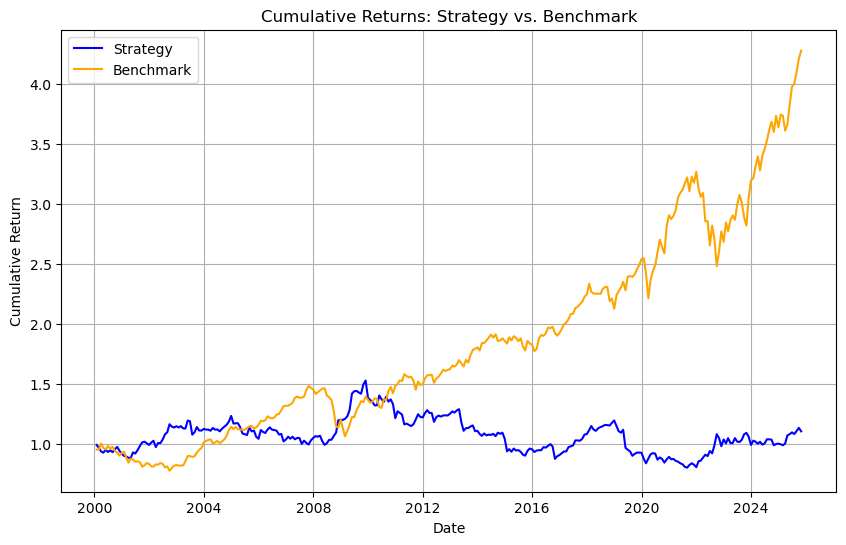

In [69]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()